In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.dates as mdates

In [115]:
plt.rcParams["figure.figsize"] = (15,8) #set size of plot
plt.rcParams.update({'font.size': 22})

In [116]:
os.chdir('/home/MA')

In [117]:
from Battery_dispatch_function import BatteryDispatch

## Define Parameter

Electricity mix carbon intensity for Norway

electricitymap.org estimation

In [118]:
grid_emissions_Norway= 31 # g CO2/kWh

In [119]:
battery_sizes = [0, 6, 12, 18, 24, 30]

In [120]:
conv_eff = 0.20 # 2020 slide 7 on https://www.ise.fraunhofer.de/content/dam/ise/de/documents/publications/studies/Photovoltaics-Report.pdf

Define PV sizing **HERE**

In [121]:
PV_size = 6 #kW_p

According to https://www.energieheld.de/solaranlage/photovoltaik and https://www.energieheld.ch/solaranlagen/photovoltaik#:~:text=Rechnen%20Sie%20im%20Durchschnitt%20etwa,dieser%20Gr%C3%B6sse%20installieren%20zu%20k%C3%B6nnen, 6 m2 are required per kW_p

In [122]:
size = 6*PV_size # m2 necessary for 6 kW_p

In [123]:
HW_boiler_eff = 1
HP_COP = 3.1
AC_EER = 8.5

In [124]:
max_c_charge = 0.25
max_c_discharge = 0.5

Roundtrip efficiency solar battery: 85% (check alternative sources) https://www.homerenergy.com/products/pro/docs/latest/battery_roundtrip_efficiency.html#:~:text=The%20battery%20round%2Dtrip%20efficiency,Typically%20it%20is%20about%2080%25.
Assumption: Losses occur during discharging only (Charging efficiency is 99% https://www.powertechsystems.eu/home/tech-corner/lithium-ion-battery-advantages/)

In [125]:
eta_discharge = 0.85

In [126]:
PV_lifetime = 25 #years

In [127]:
battery_lifetime = 15 # years

Battery production energy intensity from https://www.researchgate.net/publication/331837767_The_energetic_implications_of_introducing_lithium-ion_batteries_into_distributed_photovoltaic_systems

In [128]:
elec_battery_prod = 95.5 # kwh_el/kWh_n

Assumption: Battery production in China
at 637 g CO2/kWh
https://www.mdpi.com/1996-1073/14/4/961/pdf

In [129]:
CO2_intensity_China = 637

In [130]:
electricity_PV_production = 1597 # kWh_el kWp-1

## Start calculations

Methodology based on this paper: https://www.researchgate.net/publication/331837767_The_energetic_implications_of_introducing_lithium-ion_batteries_into_distributed_photovoltaic_systems

Get local data from https://re.jrc.ec.europa.eu/pvg_tools/en/#HR
for years 2010-2016 to average yearly variability
Solar panels were assumed to be 46 inclined towards south to maximize yearly yield without the need for sophisticated mechanic installations.

Read data into dataframe

In [131]:
HDD_CH = pd.read_csv('Data/LSZH_HDD_12C.csv')

For Norway, ENTO station south of Oslo was chosen

In [132]:
HDD_Norway = pd.read_csv('Data/ENTO_HDD_12C.csv')

In [133]:
load_CH = pd.read_pickle('Calculations/CH/load_CH_separated.pkl')

Goal: to recreate a heating demand profile for Norway based on the one provided for Switzerland.
Approach: Divide all heating energy by total of heating degree days for Switzerland, then multiply Norway's heating degree days

Calculations were carried out with base temperature of 12° Celsius which is a valid assumption based on https://www.sciencedirect.com/science/article/pii/S2352710218301086#:~:text=The%20air%20temperature%20is%20defined,the%20basis%20for%20climate%20classification.
Source for heating days : https://www.degreedays.net/#

In [134]:
Total_elec_heating_CH = sum(load_CH['Electricity for Space Heating [kWh]'])

In [135]:
Total_elec_heating_CH

1034.6743396814395

In [136]:
HDD_Norway['Date'] = pd.to_datetime(HDD_Norway['Date'], format='%d-%m-%y')

In [137]:
HDD_Norway = HDD_Norway[~((HDD_Norway.Date.dt.month == 2) & (HDD_Norway.Date.dt.day == 29))]

In [138]:
HDD_Norway_averaged = HDD_Norway.groupby([HDD_Norway["Date"].dt.month, HDD_Norway["Date"].dt.day, HDD_Norway["Date"].dt.hour]).mean()

In [139]:
HDD_Norway_averaged.index.names = ["month", "day", "hour"]

In [140]:
HDD_CH['Date'] = pd.to_datetime(HDD_CH['Date'], format='%d-%m-%y')

In [141]:
HDD_CH = HDD_CH[~((HDD_CH.Date.dt.month == 2) & (HDD_CH.Date.dt.day == 29))]

In [142]:
HDD_CH_averaged = HDD_CH.groupby([HDD_CH["Date"].dt.month, HDD_CH["Date"].dt.day, HDD_CH["Date"].dt.hour]).mean()

In [143]:
HDD_CH_averaged.index.names = ["month", "day", "hour"]

In [144]:
Total_HDD_CH = sum(HDD_CH_averaged['HDD 12'])
Total_HDD_CH

1523.0083333333332

In [145]:
Total_HDD_Norway = sum(HDD_Norway_averaged['HDD 12'])
Total_HDD_Norway

2039.9166666666645

In [146]:
ratio = Total_HDD_Norway/Total_HDD_CH

In [147]:
load_Norway = load_CH.copy()

In [148]:
load_Norway['Electricity for Space Heating [kWh]'] = ratio * load_Norway['Electricity for Space Heating [kWh]']

Alternative method: Reproduce a hourly profile for new locations based on climate pattern averaging Switzerland's daily profile

In [149]:
load_CH.index.get_level_values('hour')

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            ...
            15, 16, 17, 18, 19, 20, 21, 22, 23,  0],
           dtype='int64', name='hour', length=8760)

In [150]:
heating_hourly_averaged_CH = load_CH['Electricity for Space Heating [kWh]'].groupby(load_CH.index.get_level_values('hour')).mean()

In [151]:
heating_hourly_normalized_CH = heating_hourly_averaged_CH/sum(heating_hourly_averaged_CH)

In [152]:
load_Norway = load_CH.copy()

In [153]:
ratio_CH = Total_elec_heating_CH/Total_HDD_CH
ratio_CH # kWh/HDD

0.679362231339141

In [154]:
HDD_Norway_averaged['HDD 12'].repeat(24)

month  day  hour
1      1    0       8.600000
            0       8.600000
            0       8.600000
            0       8.600000
            0       8.600000
                      ...   
12     31   0       9.533333
            0       9.533333
            0       9.533333
            0       9.533333
            0       9.533333
Name: HDD 12, Length: 8760, dtype: float64

In [155]:
heating_hourly_normalized_CH_df = np.tile(heating_hourly_normalized_CH, 365)
len(heating_hourly_normalized_CH_df)

8760

In [156]:
load_Norway['Electricity for Space Heating [kWh]'] = HDD_Norway_averaged['HDD 12'].repeat(24).values * heating_hourly_normalized_CH_df * ratio_CH

In [157]:
sum(load_Norway['Electricity for Space Heating [kWh]'])

1385.8423384125717

In [158]:
crosscheck = Total_elec_heating_CH*Total_HDD_Norway/Total_HDD_CH
crosscheck

1385.8423384125679

In [159]:
load_Norway['Total Electricity'] = load_Norway['Electricity demand [kWh](Hourly) '] + load_Norway['Electricity for Space Heating [kWh]'] + load_Norway['Electricity for Hot Water [kWh]'] + load_Norway['Electricity for Space Cooling [kWh]']

In [160]:
load_Norway['Total Electricity without AC'] = load_Norway['Electricity demand [kWh](Hourly) '] + load_Norway['Electricity for Space Heating [kWh]'] + load_Norway['Electricity for Hot Water [kWh]']

In [161]:
total_elec_load = load_Norway['Total Electricity']

## Start processing of solar production data

In [162]:
meteo_data = pd.read_csv('Data/Timeseries_Oslo.csv')

Convert time column to datetime format to facilitate data processing

In [163]:
meteo_data['time'] = pd.to_datetime(meteo_data['time'], format='%Y%m%d:%H%M')

Get rid of leap years

In [164]:
meteo_data = meteo_data[~((meteo_data.time.dt.month == 2) & (meteo_data.time.dt.day == 29))]

Check length of dataset to be 7 years x 365 days/year x 24 hours/day = 61320 days

In [165]:
len(meteo_data)

61320

Check date of maximum value

In [166]:
meteo_data[meteo_data['G(i)'] == meteo_data['G(i)'].max()]

,time,G(i),H_sun,T2m,WS10m,Int
28451,2013-03-31 11:11:00,1125.18,34.22,2.78,1.8,0


This is the absolute amount of radiation incident on a solar cell in Zurich without accounting for the conversion efficiency. 
As expected, it occurs on the 22th of March, the date where the sun's angle is exactly perpendicular to the panel's orientation.

In [167]:
years = meteo_data.time.dt.year.unique()

In [168]:
results_all = pd.DataFrame()
results_optimization_all = pd.DataFrame()
for year in years:
    meteo_data_year = meteo_data[meteo_data.time.dt.year == year]
    hourly_average=meteo_data_year.groupby([meteo_data_year["time"].dt.month, meteo_data_year["time"].dt.day, meteo_data_year["time"].dt.hour]).mean()
    hourly_average.index.names = ["month", "day", "hour"]
    hourly_average['Prod/m2'] = hourly_average['G(i)']*0.17/1000
    hourly_average['Prod'] = hourly_average['Prod/m2']*size
    yearly_PV_prod = hourly_average['Prod'].sum()
    PV_production = hourly_average['Prod']
    power_balance = pd.DataFrame()
    power_balance['consumption'] = total_elec_load
    power_balance['from PV'] = PV_production
    power_balance['exchange grid'] = PV_production - total_elec_load
    power_balance['to Grid'] = (PV_production - total_elec_load).clip(lower=0)
    power_balance['from Grid'] = (total_elec_load - PV_production).clip(lower=0)
    power_balance = power_balance.fillna(0)
    self_consumption_kWh = sum(power_balance['consumption'] - power_balance['from Grid'])
    total_CO2_PV_prod = electricity_PV_production * PV_size * CO2_intensity_China
    reduced_CO2_PV_g = grid_emissions_Norway * self_consumption_kWh * PV_lifetime - total_CO2_PV_prod
    reduced_CO2_PV_t = reduced_CO2_PV_g/1000000
    results = pd.DataFrame()
    results['battery_size'] = battery_sizes
    results['curtailment'] = ''
    results['yearly_savings_kWh'] = ''
    for i in range(0, len(results['battery_size'])):
        powerbalance = BatteryDispatch(power_balance, results['battery_size'].values[i], eta_discharge, max_c_charge, max_c_discharge)
        results['yearly_savings_kWh'].values[i] = -sum(power_balance['Discharging'])
        results['curtailment'].values[i] = sum(power_balance['to Grid New'])/sum(power_balance['from PV'])
    results['total_savings_kWh'] = results['yearly_savings_kWh'] * PV_lifetime
    results['yearly_savings_CO2'] = results['yearly_savings_kWh'] * grid_emissions_Norway / 1000000
    results['total_CO2_grid_reduced'] = results['yearly_savings_CO2'] * PV_lifetime
    results['total_elec_battery_prod'] = 2 * (elec_battery_prod * results['battery_size']/0.8)
    results['total_CO2_battery_prod'] = results['total_elec_battery_prod'] * CO2_intensity_China / 1000000
    results['net_CO2_savings'] = results['total_CO2_grid_reduced'] - results['total_CO2_battery_prod'] 
    results['stored'] = results.iloc[0]['curtailment'] - results['curtailment']
    results.set_index("battery_size",drop=True,inplace=True)
    results['net_CO2_savings_with_PV'] = results['net_CO2_savings'] + reduced_CO2_PV_t
    PV_production_hourly = PV_production
    yearly_PV_production = sum(PV_production_hourly) 
    results['total_elec_PV_prod'] = electricity_PV_production * PV_size
    results['ESOI'] = results['total_savings_kWh'].div(results['total_elec_battery_prod'].where(results['total_elec_battery_prod'] != 0, np.nan))
    results['EROI_gen'] = yearly_PV_production*PV_lifetime/results['total_elec_PV_prod']
    results['EROI_grid_useful'] = results['EROI_gen']
    results['EROI_grid_curtailed'] = (1 - results['stored'] + eta_discharge * results['stored'])/(1/results['EROI_gen']+results['stored']/results['ESOI'])*(1-results['curtailment'])
    results['EROI_grid_curtailed'] = results['EROI_grid_curtailed'].fillna(results['EROI_gen']*(1-results['curtailment']))
    results['ESOI'] = results['ESOI'].fillna(0)
    curtailment_thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    #curtailment_thresholds = [0.4, 0.5]
    battery_size = list(range(0, 25))
    pd.options.mode.chained_assignment = None  # default='warn'
    
    results_optimization = pd.DataFrame()
    results_optimization['curtailment'] = curtailment_thresholds
    results_optimization['optimal_battery_size'] = ''    
    results_optimization['net_CO2_savings'] = ''
        
    for curtailment in curtailment_thresholds:   
        
        temp = 0
        max_power_allowed = curtailment*PV_size
        PV_production_used = PV_production.copy()
        PV_production_used[PV_production_used > max_power_allowed] = max_power_allowed
        PV_production_curtailed = PV_production - max_power_allowed
        PV_production_curtailed[PV_production_curtailed < 0] = 0
        power_balance = pd.DataFrame()
        power_balance['consumption'] = total_elec_load
        power_balance['from PV'] = PV_production_curtailed
        power_balance['exchange grid'] = PV_production_curtailed - total_elec_load
        power_balance['to Grid'] = (PV_production_curtailed - total_elec_load).clip(lower=0)
        power_balance['from Grid'] = (total_elec_load - PV_production_curtailed).clip(lower=0)
        power_balance = power_balance.fillna(0)
        
        temp = pd.DataFrame()
        temp['battery_size'] = battery_size
        temp['yearly_savings_kWh'] = ''
        temp['yearly_savings_CO2'] = ''
        temp['total_CO2_grid_reduced'] = ''
        temp['total_CO2_battery_prod'] = ''
        temp['net_CO2_savings'] = ''
        for i in range(0, len(temp['battery_size'])):
            powerbalance = BatteryDispatch(power_balance, temp['battery_size'].values[i], eta_discharge, max_c_charge, max_c_discharge)
            temp['yearly_savings_kWh'].values[i] = -sum(power_balance['Discharging'])
            temp['yearly_savings_CO2'].values[i] = temp['yearly_savings_kWh'].values[i] * grid_emissions_Norway / 1000000
            temp['total_CO2_grid_reduced'].values[i] = temp['yearly_savings_CO2'].values[i] * PV_lifetime
            temp['total_elec_battery_prod'] = 2 * (elec_battery_prod * temp['battery_size']/0.8)
            temp['total_CO2_battery_prod'].values[i] = temp['total_elec_battery_prod'].values[i] * CO2_intensity_China / 1000000
            temp['net_CO2_savings'].values[i] =  temp['total_CO2_grid_reduced'].values[i] - temp['total_CO2_battery_prod'].values[i]
        temp_max = temp[temp['net_CO2_savings']==temp['net_CO2_savings'].max()]
        results_optimization.optimal_battery_size[results_optimization.curtailment == curtailment] = temp_max['battery_size'].values
        results_optimization.net_CO2_savings[results_optimization.curtailment == curtailment] = temp_max['net_CO2_savings'].values
    results_optimization.set_index("curtailment",drop=True,inplace=True)
    results_all = results_all.append(results)
    results_optimization_all = results_optimization_all.append(results_optimization)

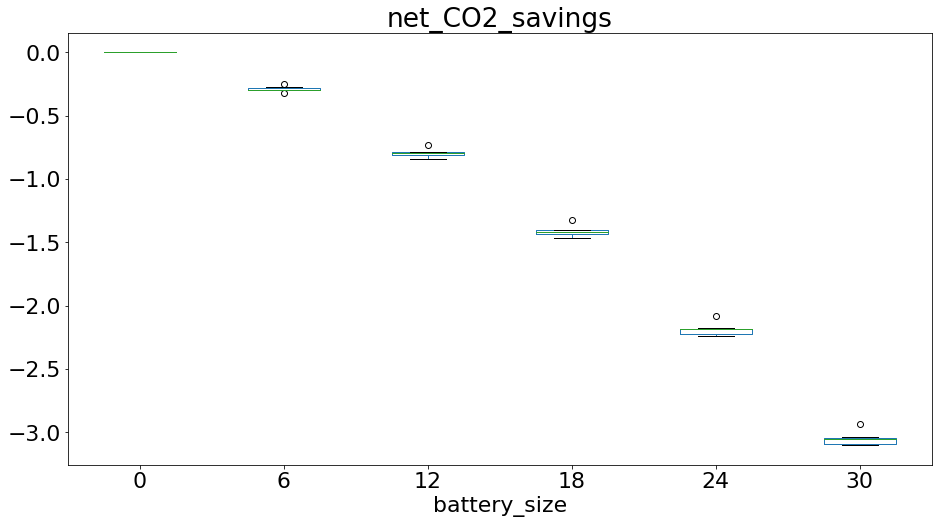

In [173]:
results_all.boxplot(by ='battery_size', column =['net_CO2_savings'], grid = False)
plt.suptitle('');

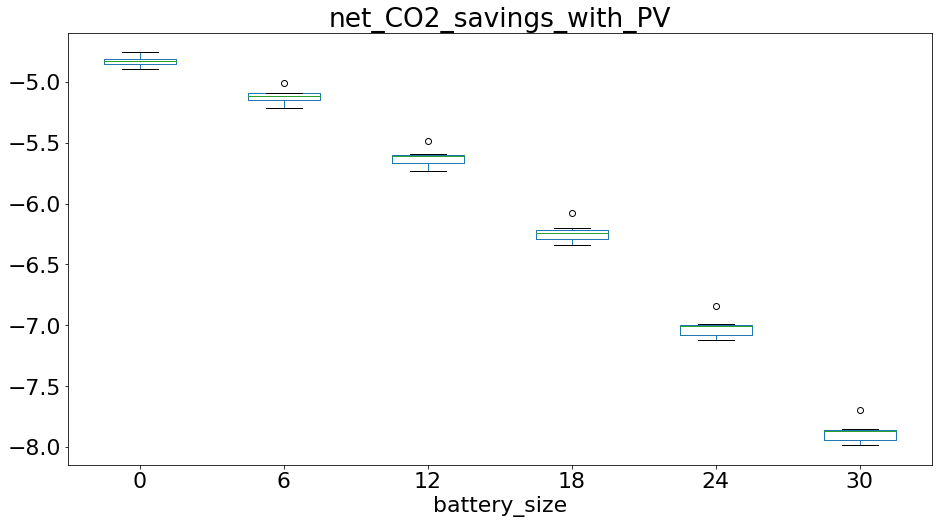

In [174]:
results_all.boxplot(by ='battery_size', column =['net_CO2_savings_with_PV'], grid = False)
plt.suptitle('');

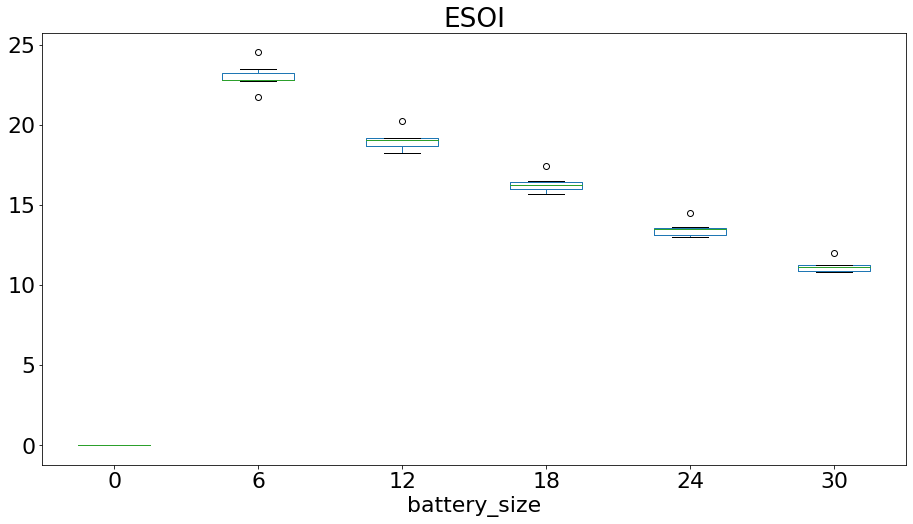

In [169]:
results_all.boxplot(by ='battery_size', column =['ESOI'], grid = False)
plt.suptitle('');

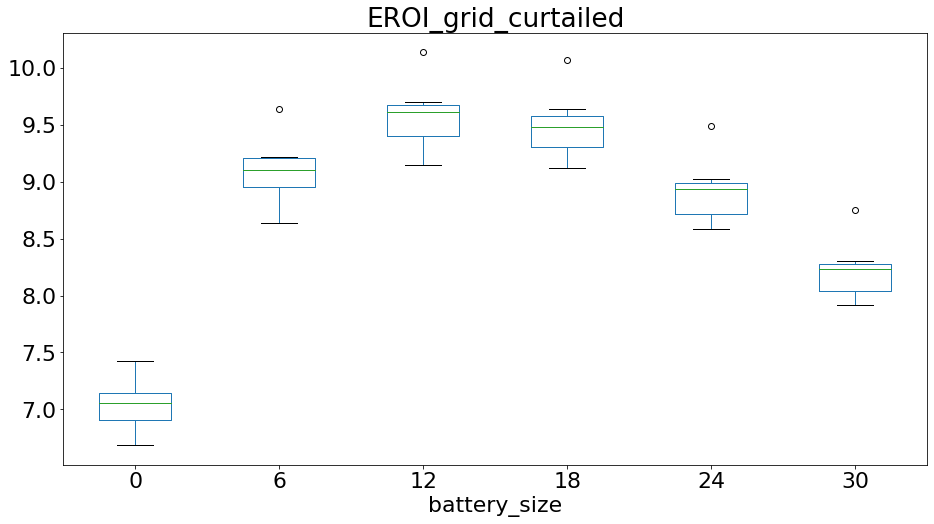

In [170]:
results_all.boxplot(by ='battery_size', column =['EROI_grid_curtailed'], grid = False)
plt.suptitle('');

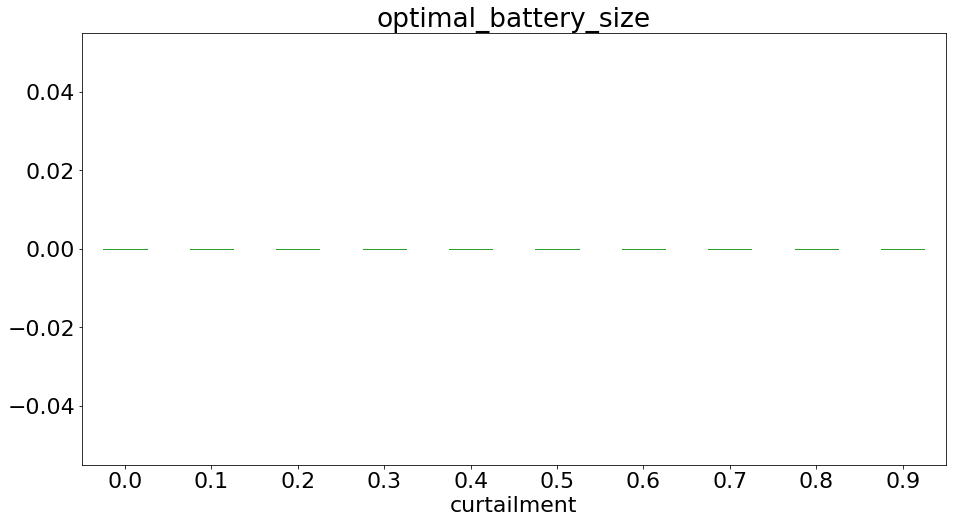

In [171]:
results_optimization_all.boxplot(by ='curtailment', column =['optimal_battery_size'], grid = False)
plt.suptitle('');

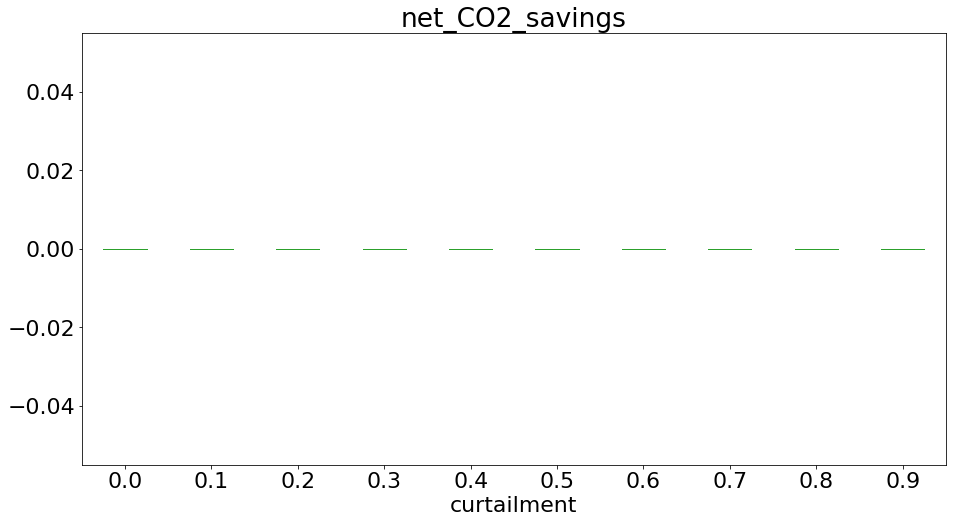

In [172]:
results_optimization_all.boxplot(by ='curtailment', column =['net_CO2_savings'], grid = False)
plt.suptitle('');